# PINN RNN POD reduction

In [53]:
import numpy as np
# import pandas as pd
# from scipy import sparse
# from scipy.sparse import csr_matrix
import time
import datetime
import sys
import os
from IPython.display import display, Markdown
import platform
from tqdm import tqdm
import matplotlib.pyplot as plt
# from matplotlib import colormaps
# import random
import json
import seaborn as sns

import sklearn
# from sklearn.metrics import root_mean_squared_error
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
# import torch.nn.functional as F
# from torchvision import datasets, transforms
# import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, TensorDataset

np.set_printoptions(threshold=sys.maxsize)
torch.set_default_dtype(torch.float32)

# get the directory path of the file
dir_path = os.getcwd()
# print(dir_path)

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from plot_functions import *

Configuración global de Matplotlib

In [54]:
plt.rcParams.update({
    # 'text.usetex': True,  # Usar LaTeX para el texto (Local)
    'text.usetex': False,  # NO Usar LaTeX para el texto (Colab)
    'font.family': 'serif',  # Fuente serif
    # 'figure.figsize': (10, 6),  # Tamaño de la figura
    'axes.labelsize': 12,  # Tamaño de las etiquetas de los ejes
    'axes.titlesize': 14,  # Tamaño del título
    'legend.fontsize': 12,  # Tamaño de la leyenda
    'xtick.labelsize': 10,  # Tamaño de las etiquetas del eje x
    'ytick.labelsize': 10,  # Tamaño de las etiquetas del eje y
    'axes.grid': True,  # Habilitar la cuadrícula
    'grid.alpha': 0.75,  # Transparencia de la cuadrícula
    'grid.linestyle': '--'  # Estilo de la línea de la cuadrícula
})

# Configuración de Seaborn
sns.set_context('paper')
sns.set_style('whitegrid')

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print('Using device:', device)

Using device: cuda


In [56]:
system_specs = {
    "os": platform.system(),  # e.g. "Linux", "Windows", "Darwin"
    "os_version": platform.version(),
    "machine": platform.machine(),  # e.g. "x86_64"
    "processor": platform.processor(),  # e.g. "Intel64 Family 6 Model 158"
    "python_version": platform.python_version(),
    "device": str(device)
}
if torch.cuda.is_available():
    system_specs["gpu_name"] = torch.cuda.get_device_name(0)
    system_specs["gpu_memory_total_GB"] = round(torch.cuda.get_device_properties(0).total_memory / (1024**3), 2)
    system_specs["cuda_version"] = torch.version.cuda

<a id='section_1'></a>
# PCB solver trasient

In [57]:
sys.path.append('../scripts') 

from PCB_solver_tr import PCB_solver_main, PCB_case_1, PCB_case_2

<a id='section_1_1'></a>
## 1.1. PCB case 1

In [58]:
# def PCB_case_1(L:float=0.1,thickness:float=0.001,m:int=3,board_k:float=10,ir_emmisivity:float=0.8,
#                     T_interfaces:list=[250,250,250,250],Q_heaters:list=[1.0,1.0,1.0,1.0],Tenv:float=250,display:bool = False):
#     """
#     Caso 1. 
#     PCB cuadrada de lado L con 4 heaters simétricamente colocados en coordenadas [(L/4,L/2),(L/2,L/4),(3*L/4,L/2),(L/2,3*L/4)]
#     y con 4 nodos de interfaz situados en coordenadas [(0,0),(L,0),(L,L),(0,L)].
#     Variables de entrada (unidades entre [], si no hay nada es adimensional):
#                         -- L (int) = dimensiones de la placa. [m]
#                         -- thickness (float) = espesor de la placa. [m]
#                         -- m (int) = valor de refinamiento de malla. --> el número de nodos en x e y es n = 4*m+1. En el caso predeterminado son 12x12 nodos.
#                         -- board_k (float) = conductividad térmica del material de la placa. [W/(K*m)]
#                         -- ir_emmisivity (float) = emisividad infrarroja del recubrimiento óptico de la PCB (la pintura). 
#                         -- T_interfaces (lista de 4 elementos) = temperatura de las 4 interfaces. [K]
#                         -- Q_heaters (lista de 4 elementos) = potencia disipada por los heaters. [W]
#                         -- Tenv (float) = temperatura del entorno. [K]
#                         -- display (bool) = mostrar las temperaturas.
#     Variables de salida:
#                         -- T (numpy.array con dimension n = nx*ny) = vector con las temperaturas de los nodos (más información mirar en la descripción de **PCB_solver_main()**).
#                         -- interfaces (diccionario {key = id del nodo, value = temperatura del nodo [K]}) = temperatura de las interfaces.
#                         -- heaters (diccionario {key = id del nodo, value = disipación del nodo [W]}) = potencia disipada por los heaters.
#     """

#     n = 4*m+1

#     id_Qnodes = [int((n-1)/4+(n-1)/2*n),int((n-1)/2+(n-1)/4*n),int(3*(n-1)/4+(n-1)/2*n),int((n-1)/2+3*(n-1)/4*n)]
#     heaters = {id_Qnodes[0]:Q_heaters[0],id_Qnodes[1]:Q_heaters[1],id_Qnodes[2]:Q_heaters[2],id_Qnodes[3]:Q_heaters[3]}

#     id_inodes = [0,n-1,n*n-1,n*n-n]
#     interfaces = {id_inodes[0]:T_interfaces[0],id_inodes[1]:T_interfaces[1],id_inodes[2]:T_interfaces[2],id_inodes[3]:T_interfaces[3]}

#     T = PCB_solver_main(Lx=L, Ly=L, thickness=thickness,nx=n,ny=n,board_k=board_k,ir_emmisivity=ir_emmisivity,
#                     Tenv=Tenv,interfaces=interfaces,heaters=heaters, display=display)
    
#     return T,interfaces,heaters

<a id='section_1_2'></a>
## 1.2. PCB case 2

In [59]:
# def PCB_case_2(solver: str = 'steady', L:float=0.1,thickness:float=0.001,m:int=3,board_k:float=10, board_c:float=900, board_rho: float = 2700, ir_emmisivity:float=0.8,
#                     T_interfaces:list=[250,250,250,250],Q_heaters:list=[1.0,1.0,1.0,1.0],Tenv:float=250,display:bool = False, time:float = 0.0, dt:float = 0.0, T_init:float = 298.0):
#     """
#     Caso 1
#     PCB cuadrada de lado L con 4 heaters colocados en coordenadas [(L/4,L/2),(L/2,L/4),(L/4,3*L/4),(3*L/4,3*L/4)]
#     y con 4 nodos de interfaz situados en coordenadas [(0,0),(L,0),(L,L),(0,L)].
#     Variables de entrada (unidades entre [], si no hay nada es adimensional):
#                         -- L (int) = dimensiones de la placa. [m]
#                         -- thickness (float) = espesor de la placa. [m]
#                         -- m (int) = valor de refinamiento de malla. --> el número de nodos en x e y es n = 4*m+1. En el caso predeterminado son 12x12 nodos.
#                         -- board_k (float) = conductividad térmica del material de la placa. [W/(K*m)]
#                         -- ir_emmisivity (float) = emisividad infrarroja del recubrimiento óptico de la PCB (la pintura). 
#                         -- T_interfaces (lista de 4 elementos) = temperatura de las 4 interfaces (250 - 350 K). [K]
#                         -- Q_heaters (lista de 4 elementos) = potencia disipada por los heaters (0.1 - 5.0 W). [W]
#                         -- Tenv (float) = temperatura del entorno (250 - 350 K). [K]
#                         -- display (bool) = mostrar las temperaturas.
#     Variables de salida:
#                         -- T (numpy.array con dimension n = nx*ny) = vector con las temperaturas de los nodos (más información mirar en la descripción de **PCB_solver_main()**).
#                         -- interfaces (diccionario {key = id del nodo, value = temperatura del nodo [K]}) = temperatura de las interfaces.
#                         -- heaters (diccionario {key = id del nodo, value = disipación del nodo [W]}) = potencia disipada por los heaters.
#     """

#     n = 4*m+1

#     id_Qnodes = [int((n-1)/4+(n-1)/2*n),int((n-1)/2+(n-1)/4*n),int((n-1)/4+3*(n-1)/4*n),int(3*(n-1)/4+3*(n-1)/4*n)]
#     heaters = {id_Qnodes[0]:Q_heaters[0],id_Qnodes[1]:Q_heaters[1],id_Qnodes[2]:Q_heaters[2],id_Qnodes[3]:Q_heaters[3]}

#     id_inodes = [0,n-1,n*n-1,n*n-n]
#     interfaces = {id_inodes[0]:T_interfaces[0],id_inodes[1]:T_interfaces[1],id_inodes[2]:T_interfaces[2],id_inodes[3]:T_interfaces[3]}

#     T, time_array = PCB_solver_main(solver = solver, Lx=L, Ly=L, thickness=thickness,nx=n,ny=n,board_k=board_k, board_c=board_c, board_rho=board_rho, ir_emmisivity=ir_emmisivity,
#                     Tenv=Tenv,interfaces=interfaces,heaters=heaters, display=display, time=time, dt=dt, T_init = T_init)
    
#     return T, time_array, interfaces, heaters

<a id='section_1_3'></a>
## 1.3. PCB solver main

In [60]:
# def PCB_solver_main(solver:str, Lx:float,Ly:float,thickness:float,nx:int,ny:int,board_k:float,  ir_emmisivity:float,
#                     Tenv:float,interfaces:dict,heaters:dict, display:bool = False, maxiters:int = 1000, objtol:int = 0.01, board_c:float=900, board_rho: float = 2700, time:float = 0.0, dt:float = 0.0,T_init:float = 298.0):
#     '''
#     Función solver del problema de PCB rectangular en un entorno radiativo formado por un cuerpo negro a temperatura Tenv. 
#     Los nodos van numerados siguiendo el esquema de la figura, los nodos se ordenan de forma creciente filas.

#     26---27---28---29---30    
#     |    |    |    |    |  
#     20---21---22---23---24    
#     |    |    |    |    |   
#     15---16---17---18---19    
#     |    |    |    |    |
#     10---11---12---13---14    
#     |    |    |    |    |    y
#     5----6----7----8----9    ^
#     |    |    |    |    |    |
#     0----1----2----3----4    ---> x

#     Variables de entrada (unidades entre [], si no hay nada es adimensional):
#                         -- Lx (int) = dimension x de la placa. [m]
#                         -- Lx (int) = dimension y de la placa. [m]
#                         -- thickness (float) = espesor de la placa. [m]
#                         -- nx (int) = número de nodos en el eje x (en la figura de ejemplo son 5).
#                         -- ny (int) = número de nodos en el eje y (en la figura de ejemplo son 6).
#                         -- board_k (float) = conductividad térmica del material de la placa. [W/(K*m)]
#                         -- ir_emmisivity (float) = emisividad infrarroja del recubrimiento óptico de la PCB (la pintura).
#                         -- Tenv (float) = temperatura del entorno. [K]
#                         -- interfaces (diccionario {key = id del nodo, value = temperatura del nodo [K]}) = temperatura de las interfaces.
#                         -- heaters (diccionario {key = id del nodo, value = disipación del nodo [W]}) = potencia disipada por los heaters.
#                         -- display (bool) = mostrar las temperaturas.
#                         -- maxiters (int) = máximas iteraciones del solver. Mantener el valor predeterminado salvo si la convergencia es muy lenta (salta error en la linea 203). 
#                         -- objtol (int) = tolerancia objetivo del solver. Mantener el valor predeterminado salvo si no se llega a convergencia (salta error en la linea 203).
#     Variables de salida:
#                         -- T (numpy.array con dimension n = nx*ny) = vector con las temperaturas ordenadas como en la figura de ejemplo.
#     '''
    
#     n_nodes = nx*ny # número total de nodos

#     # cálculo de los GLs y GRs
#     dx = Lx/(nx-1)
#     dy = Ly/(ny-1)
#     GLx = thickness*board_k*dy/dx
#     GLy = thickness*board_k*dx/dy
#     GR = 2*dx*dy*ir_emmisivity

#     # Generación de la matriz de acoplamientos conductivos [K]. 
#     K_cols = []
#     K_rows = []
#     K_data = []
#     for j in range(ny):
#         for i in range(nx):
#             id = i + nx*j
#             if id in interfaces:
#                 K_rows.append(id)
#                 K_cols.append(id)
#                 K_data.append(1)
#             else:
#                 GLii = 0
#                 if i+1 < nx:
#                     K_rows.append(id)
#                     K_cols.append(id+1)
#                     K_data.append(-GLx)
#                     GLii += GLx
#                 if i-1 >= 0:
#                     K_rows.append(id)
#                     K_cols.append(id-1)
#                     K_data.append(-GLx)
#                     GLii += GLx
#                 if j+1 < ny:
#                     K_rows.append(id)
#                     K_cols.append(id+nx)
#                     K_data.append(-GLx)
#                     GLii += GLy
#                 if j-1 >= 0:
#                     K_rows.append(id)
#                     K_cols.append(id-nx)
#                     K_data.append(-GLx)
#                     GLii += GLy
#                 K_rows.append(id)
#                 K_cols.append(id)
#                 K_data.append(GLii)
#     K = sparse.csr_matrix((K_data,(K_rows,K_cols)),shape=(n_nodes,n_nodes))

#     # Creación de la matriz de acoplamientos radiativos [E]
#     E_data = []
#     E_id = []
#     for id in range(n_nodes):
#         if id not in interfaces:
#             E_id.append(id)
#             E_data.append(GR)
#     E = sparse.csr_matrix((E_data,(E_id,E_id)),shape=(n_nodes,n_nodes))

#     # Creación del vector {Q}.
#     Q = np.zeros(n_nodes,dtype=np.double)
#     for id in range(n_nodes):
#         if id in interfaces:
#             Q[id] = interfaces[id]
#         elif id in heaters:
#             Q[id] = heaters[id]
    
#     # Resolución de la ecuación no lineal [K]{T} + Boltzmann_cte*[E]({T^4} - Tenv^4) = {Q} 
#     # mediante la resolución iterativa de la ecuación [A]{dT_i} = {b}, donde:
#     #           -- [A] = [K] + 4*Boltzmann_cte*[E].*{T_i^3} (.* = multiplicación elemento a elemento)
#     #           -- {b} = {Q} - [K]*{T_i} - [E]*({T_i^4}-Tenv^4)
#     #           -- {T_i+1} = {T_i} + {dT_i}
            
#     Boltzmann_cte = 5.67E-8
#     tol = 100
#     it = 0

#     if solver == 'steady':
#         T = np.full(n_nodes, T_init, dtype=np.double)
#         while tol > objtol and it < maxiters:
#             b = Q - K.__matmul__(T) - Boltzmann_cte * E.__matmul__(T**4-Tenv**4)
#             A = K + 4 * Boltzmann_cte * E.multiply(T**3)
#             dT = sparse.linalg.spsolve(A,b)
#             T += dT
#             tol = max(abs(dT))
#             it = it+1

#         if tol > objtol:
#             print("ERROR in PCB SOLVER MAIN. Convergence was not reached.")
#             exit(1)

#         if display == True:
#             fig, ax = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
#             psm = ax.pcolormesh(T.reshape(ny,nx), cmap=colormaps['jet'], rasterized=True, vmin=np.min(T), vmax=np.max(T))
#             fig.colorbar(psm, ax=ax)
#             plt.title('Temperature field')
#             plt.show()
#         return T, None
    
#     elif solver == 'transient':
#         alpha = board_k/(board_rho*board_c) # thermal difusivity.
#         if alpha*dt/(0.5*(dx+dy))**2 > 0.5: # stability criterion for Euler scheeme. --> the criterion can be found here (eq 11): https://en.wikipedia.org/wiki/Von_Neumann_stability_analysis
#             print("Excesive timestep size. Euler method becomes unstable.")
#             exit(1)
#         T = np.full(n_nodes, T_init, dtype=np.double) 
#         interface_nodes_id = np.array(list(interfaces.keys()))
#         heater_nodes_id = np.array(list(heaters.keys()))
#         for i_node in interfaces: # changing the temperature of the interface nodes from T_init to the proper temperature of the interface.
#             T[i_node] = interfaces[i_node]
#         T_array = np.expand_dims(T, axis=0)
#         time_array = np.array([0.0])
#         ti = 0.0
#         while ti < time:
#             dTdt = (Q - K.__matmul__(T) - Boltzmann_cte * E.__matmul__(T**4 - Tenv**4)) / (board_c * board_rho * thickness * dx * dy)
#             dTdt[interface_nodes_id] = 0 # cancel de derivative term in the interface nodes. 
#             dT = dTdt * dt
#             T += dT
#             T_array = np.concatenate((T_array, np.expand_dims(T, axis=0)), axis=0)
#             ti += dt
#             time_array = np.append(time_array, ti)

#         if display == True:
#             fig1, ax1 = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
#             psm = ax1.pcolormesh(T.reshape(ny,nx), cmap=colormaps['jet'], rasterized=True, vmin=np.min(T), vmax=np.max(T))
#             fig1.colorbar(psm, ax=ax1)
#             plt.title('Temperature field at time '+str(time)+' [s]')
#             plt.show()

#             fig2, ax2 = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
#             ax2.plot(time_array,T_array[:,heater_nodes_id])
#             plt.title("heaters temperature")
#             plt.xlabel("time [s]")
#             plt.ylabel("temperature [K]")
#             legend = list(heaters.keys())
#             plt.legend(legend)
#             plt.show()

#         return T_array, time_array

<a id='section_1_4'></a>
## 1.4. Ejemplo de uso con los valores predeterminados

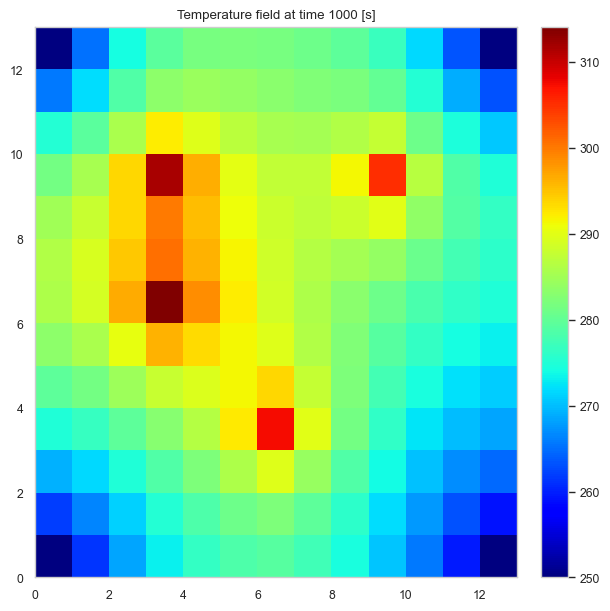

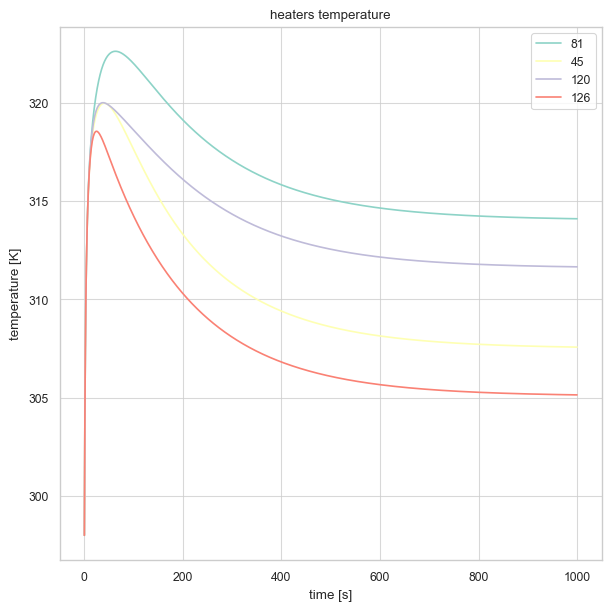

In [61]:
T2, time2, interfaces2, heaters2 = PCB_case_2(solver = 'transient', display=True, time = 1000, dt = 1, T_init = 298.0)

# Dataset generation

## Dataset class

In [62]:
sys.path.append('../Convolutional_NN') 

from Dataset_Class import *

## Dataset Generation

Dataset parameters: variable max and min values, number of data, boundary conditions...

In [63]:
n_train = 500
n_test = 100
n_validation = 50

nodes_side = 13
time_sim = 100
dt = 1
T_init = 298.0

n_data = n_train+n_test+n_validation

input = []
output = []

np.random.seed(0)

Q_random = np.random.uniform(0.1, 1.25, (n_data, 4))
T_interfaces_random = np.random.uniform(260, 310, (n_data, 4))
T_env_random = np.random.uniform(260, 310, n_data)

Iterating to get the full dataset

In [64]:
time_start = time.time()

for i in range(n_data):
    
    # Print iteration number
    if i%100 == 0:
        print("Generating element number: ",i)
        
    # Generate the data
    T, _, _, _ = PCB_case_2(solver = 'transient', display=False, time = time_sim, dt = dt, T_init = T_init, Q_heaters = Q_random[i], T_interfaces = T_interfaces_random[i], Tenv = T_env_random[i]) # heaters in default position
    # T = T.reshape(T.shape[0], nodes_side,nodes_side) # reshaping the data grid-shape
    
    # Append the data to the list
    output.append(T)
    input1 = []
    # print(T_interfaces_random[i],Q_random[i],T_env_random[i]) # DEBUGGING
    input1 = np.concatenate((T_interfaces_random[i],Q_random[i],[T_env_random[i]]),axis=0)
    # print(input1) # DEBUGGING
    input.append(input1)
    
time_end = time.time()
time_generation_data = time_end-time_start
print("Time to generate the data: ",time_generation_data)

# transform the lists into numpy arrays
input = np.array(input)
output = np.array(output)
output = output.reshape(output.shape[0], output.shape[1], nodes_side,nodes_side) # reshaping the data grid-shape
# print(output.shape) # DEBUGGING

Generating element number:  0
Generating element number:  100
Generating element number:  200
Generating element number:  300
Generating element number:  400
Generating element number:  500
Generating element number:  600
Time to generate the data:  3.7549352645874023


Transform dataset into torch tensors

In [65]:
# print(input.shape) # DEBUGGING
input = torch.tensor(input,dtype=torch.float32)#.to(device)
# print(output.shape) # DEBUGGING
output = torch.tensor(output,dtype=torch.float32)#.to(device)

T_interfaces = np.zeros((n_data, nodes_side,nodes_side))
Q_heaters = np.zeros((n_data, nodes_side,nodes_side))
T_env = np.zeros((n_data, nodes_side,nodes_side))

for i in range(n_data):
    Q_heaters[i,6,3], Q_heaters[i,3,6],Q_heaters[i,9,3], Q_heaters[i,9,9] = Q_random[i]
    T_interfaces[i,0,0], T_interfaces[i,0,nodes_side-1], T_interfaces[i,nodes_side-1,nodes_side-1], T_interfaces[i,nodes_side-1,0] = T_interfaces_random[i]
    T_env[i,:,:] = T_env_random[i]
    
Q_heaters = torch.tensor(Q_heaters,dtype=torch.float32)#.to(device)
T_env = torch.tensor(T_env,dtype=torch.float32)#.to(device)
T_interfaces = torch.tensor(T_interfaces,dtype=torch.float32)#.to(device)

Calculate averages and standard deviation

In [66]:
# calculate averages and standard deviations
T_interfaces_mean = T_interfaces.mean() # careful because calculated with lots of zeros
T_interfaces_std = T_interfaces.std()
Q_heaters_mean = Q_heaters.mean() # careful because calculated with lots of zeros
Q_heaters_std = Q_heaters.std()
T_env_mean = T_env.mean()
T_env_std = T_env.std()
output_mean = output.mean() 
output_std = output.std()

mean_values = np.array([T_interfaces_mean, Q_heaters_mean, T_env_mean])
std_values = np.array([T_interfaces_std, Q_heaters_std, T_env_std])

print(T_interfaces_mean, T_interfaces_std, Q_heaters_mean, Q_heaters_std, T_env_mean, T_env_std, output_mean, output_std) # DEBUGGING
# print(T_interfaces[1, : , :]) # DEBUGGING
# print(torch.count_nonzero(Q_heaters[1, : , :])) # DEBUGGING

tensor(6.7303) tensor(43.2819) tensor(0.0161) tensor(0.1156) tensor(285.4996) tensor(14.5446) tensor(298.7033) tensor(6.8263)


Saving dataset

In [67]:
dataset_test = PCBDataset(T_interfaces[:n_test,:,:],Q_heaters[:n_test,:,:],T_env[:n_test,:,:],output[:n_test,:,:],
                 T_interfaces_mean,T_interfaces_std,Q_heaters_mean,
                 Q_heaters_std,T_env_mean,T_env_std,output_mean,
                 output_std)

dataset_train = PCBDataset(T_interfaces[n_test:-n_validation,:,:],Q_heaters[n_test:-n_validation,:,:],T_env[n_test:-n_validation,:,:],output[n_test:-n_validation,:,:],
                 T_interfaces_mean,T_interfaces_std,Q_heaters_mean,
                 Q_heaters_std,T_env_mean,T_env_std,output_mean,
                 output_std)

dataset_validation = PCBDataset(T_interfaces[-n_validation:,:,:],Q_heaters[-n_validation:,:,:],T_env[-n_validation:,:,:],output[-n_validation:,:,:],
                 T_interfaces_mean,T_interfaces_std,Q_heaters_mean,
                 Q_heaters_std,T_env_mean,T_env_std,output_mean,
                 output_std)

dataset = PCBDataset(T_interfaces,Q_heaters,T_env,output,
                 T_interfaces_mean,T_interfaces_std,Q_heaters_mean,
                 Q_heaters_std,T_env_mean,T_env_std,output_mean,
                 output_std)


# path directorie for saving datasets
path = os.path.join(dir_path,'Datasets')
if not os.path.exists(path):
    os.makedirs(path)
    
torch.save(dataset, os.path.join(dir_path,"Datasets",'PCB_transient_dataset.pth'))
torch.save(dataset_test, os.path.join(dir_path,"Datasets",'PCB_transient_dataset_test.pth'))
torch.save(dataset_train, os.path.join(dir_path,"Datasets",'PCB_transient_dataset_train.pth'))
torch.save(dataset_validation, os.path.join(dir_path,"Datasets",'PCB_transient_dataset_validation.pth'))

# Convolutional LSTM

#### Common to all

Hyperparameters of training

In [68]:
epochs = 200
lr = 1e-3
lrdecay = 0.1
lrdecay_patience = 10
early_stop_patience = 50
batch_size = 32

hidden_layers = 32
kernel_size = (3, 3)

## No-physics Convolutional LSTM

### Model definition

In [69]:
# from Dataset_Class import PCBDataset  # Ensure the PCBDataset class is imported

dataset_path = os.path.join(dir_path,'Datasets')

# Allowlist the PCBDataset class for safe loading
torch.serialization.add_safe_globals([PCBDataset])

dataset_test:PCBDataset = torch.load(os.path.join(dataset_path,'PCB_transient_dataset_test.pth'), weights_only=True)
dataset_train:PCBDataset = torch.load(os.path.join(dataset_path,'PCB_transient_dataset_train.pth'), weights_only=True)
dataset_validation:PCBDataset = torch.load(os.path.join(dataset_path,'PCB_transient_dataset_validation.pth'), weights_only=True)

input_train, output_train = dataset_train[:]
sequence_length = output_train.shape[1]
input_train = input_train.unsqueeze(1).repeat(1, sequence_length, 1, 1, 1) # to mantain boundary conditions in all steps
output_train = output_train.unsqueeze(2)  # 
input_train = input_train.to(device)
output_train = output_train.to(device)

input_test, output_test = dataset_test[:]
input_test = input_test.unsqueeze(1).repeat(1, sequence_length, 1, 1, 1) # to mantain boundary conditions in all steps
output_test = output_test.unsqueeze(2)  #
input_test = input_test.to(device)
output_test = output_test.to(device)

input_validation, output_validation = dataset_validation[:]
input_validation = input_validation.unsqueeze(1).repeat(1, sequence_length, 1, 1, 1) # to mantain boundary conditions in all steps
output_validation = output_validation.unsqueeze(2)  #
input_validation = input_validation.to(device)
output_validation = output_validation.to(device)

In [70]:
def get_input(Q_heaters_in, T_interfaces_in, T_env_in, nodes_side=13, sequence_length=sequence_length, mean_values=mean_values, std_values=std_values):
    
    T_interfaces_in = (T_interfaces_in-mean_values[0])/std_values[0]
    Q_heaters_in = (Q_heaters_in-mean_values[1])/std_values[1]
    T_env_in = (T_env_in-mean_values[2])/std_values[2]
    
    
    T_interfaces1 = np.zeros((nodes_side,nodes_side))
    Q_heaters1 = np.zeros((nodes_side,nodes_side))
    T_env1 = np.zeros((nodes_side,nodes_side))
    
    T_interfaces1[0,0], T_interfaces1[0,nodes_side-1], T_interfaces1[nodes_side-1,nodes_side-1], T_interfaces1[nodes_side-1,0] = T_interfaces_in
    Q_heaters1[6,3], Q_heaters1[3,6], Q_heaters1[9,3], Q_heaters1[9,9] = Q_heaters_in
    T_env1[:,:] = T_env_in
    
    Q_heaters1 = torch.tensor(Q_heaters1,dtype=torch.float32)#.to(device)
    T_env1 = torch.tensor(T_env1,dtype=torch.float32)#.to(device)
    T_interfaces1 = torch.tensor(T_interfaces1,dtype=torch.float32)#.to(device)
    
    input1 = torch.empty(3, nodes_side, nodes_side)
    input1[0,:,:] = T_interfaces1
    input1[1,:,:] = Q_heaters1
    input1[2,:,:] = T_env1
    
    input1 = input1.unsqueeze(0).unsqueeze(1).repeat(1, sequence_length, 1, 1, 1).to(device) # to mantain boundary conditions in all steps
    
    return input1

In [71]:
from convlstm import *

class PCB_ConvLSTM(nn.Module):
    def __init__(self, input_channels=3, hidden_dim=32, kernel_size=(3, 3), height=13, width=13):
        super().__init__()
        self.convlstm = ConvLSTM(input_dim=input_channels,
                                 hidden_dim=[hidden_dim],
                                 kernel_size=kernel_size,
                                 num_layers=1,
                                 batch_first=True,
                                 bias=True,
                                 return_all_layers=False)
        
        self.decoder = nn.Conv2d(hidden_dim, 1, kernel_size=1)

    def forward(self, x):
        # x: (B, T, C, H, W)
        lstm_out, _ = self.convlstm(x)  # lstm_out[0]: (B, T, hidden_dim, H, W)

        # Apply decoder to each time step
        decoded = [self.decoder(lstm_out[0][:, t]) for t in range(x.size(1))]
        output = torch.stack(decoded, dim=1)  # (B, T, 1, H, W)
        return output

Definición del modelo

In [72]:
train_ds = TensorDataset(input_train, output_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

test_ds = TensorDataset(input_test, output_test)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

model = PCB_ConvLSTM(input_channels=3, hidden_dim=hidden_layers, kernel_size=kernel_size, height=13, width=13).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=lrdecay, patience=lrdecay_patience, verbose=True)

# DEBUGGING
batch = next(iter(train_dl))
x, y = batch

print(f"x está en: {x.device}")
print(f"y está en: {y.device}")
print(f"model está en: {next(model.parameters()).device}")

x está en: cuda:0
y está en: cuda:0
model está en: cuda:0


c:\Users\ismael.gallo\anaconda3\envs\ismael_minimal\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Training

Training and saving best model with best parameters.

In [73]:
train_loss = []
test_loss = []
best_test_loss = np.inf
epochs_without_improvement = 0

kernel_string = f"{kernel_size[0]}x{kernel_size[1]}"
model_dir = os.path.join(dir_path, 'models', 'ConvLSTM')
os.makedirs(model_dir, exist_ok=True)

# Nombre del archivo con hiperparámetros
filename = f"PCB_ConvLSTM_nt{n_train}_{time_sim}s_bs{batch_size}_h{hidden_layers}_k{kernel_string}.pth"

# Ruta completa del modelo
model_path = os.path.join(model_dir, filename)

if os.path.exists(model_path):
    display(Markdown(f"**❌ El modelo `{filename}` ya existe. Se omite esta celda para evitar sobreescritura.**"))
    # Detiene la ejecución de esta celda sin interrumpir el notebook
    raise SystemExit

# ruta para el JSON
json_path = model_path.replace('.pth', '.json')

start_time_training = time.time()
start_datetime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    start_time_epoch = time.time()

    # Entrenamiento
    for x, y in tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs} - Training", leave=False):
        optimizer.zero_grad()
        y_hat = model(x)
        # print(y_hat.shape, y.shape) # DEBUGGING
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.detach().item()

    epoch_train_loss = total_loss / len(train_dl)
    train_loss.append(epoch_train_loss)

    # Validación
    model.eval()
    total_test_loss = 0.0
    with torch.no_grad():
        for x_test, y_test in test_dl:
            y_pred = model(x_test)
            test = criterion(y_pred, y_test)
            total_test_loss += test.item()

    epoch_test_loss = total_test_loss / len(test_dl)
    test_loss.append(epoch_test_loss)
    
    # Scheduler update
    scheduler.step(epoch_test_loss)
    
    # Early stopping check
    if epoch_test_loss < best_test_loss:
        best_test_loss = epoch_test_loss
        
        # Guardar el modelo
        torch.save(model.state_dict(), model_path)
        
        elapsed_training = time.time() - start_time_training
        elapsed_minutes = elapsed_training / 60
    
        # Guardar hiperparámetros en JSON  
        params = {
            'start_datetime': start_datetime,
            'training_duration_minutes': elapsed_minutes,
            "system_specs": system_specs,
            'hidden_layers': hidden_layers,
            'kernel_size': kernel_string,
            'batch_size': batch_size,
            'lr': lr,
            "scheduler":{
                "type": "ReduceLROnPlateau",
                "factor": lrdecay,
                "patience": lrdecay_patience
            },
            'early_stop_patience': early_stop_patience,
            'epochs_trained': epoch + 1,
            'best_test_loss': best_test_loss,
            "train_loss": list(map(float, train_loss)),
            "test_loss": list(map(float, test_loss)),
        }
        
        with open(json_path, 'w') as f:
            json.dump(params, f, indent=4)
    
        # print(f"✓ Saving model (epoch {epoch+1}) | test_loss improved to {best_test_loss:.6f}")
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        # print(f"No improvement for {epochs_without_improvement} epoch(s)")
        
    if epochs_without_improvement >= early_stop_patience:
        print(f"⚠️ Early stopping at epoch {epoch+1} — no improvement for {early_stop_patience} epochs.")
        break

    # Estadísticas finales de la época
    elapsed_epoch = time.time() - start_time_epoch
    # print(f"Epoch {epoch+1:3d} | Train Loss: {epoch_train_loss:.6f} | Test Loss: {epoch_test_loss:.6f} | Time: {elapsed_epoch:.2f}s")
    
print(f"Entrenamiento finalizado en {elapsed_minutes:.2f} minutos.")

Entrenamiento finalizado en 39.41 minutos.


Plotting validation loss and train loss

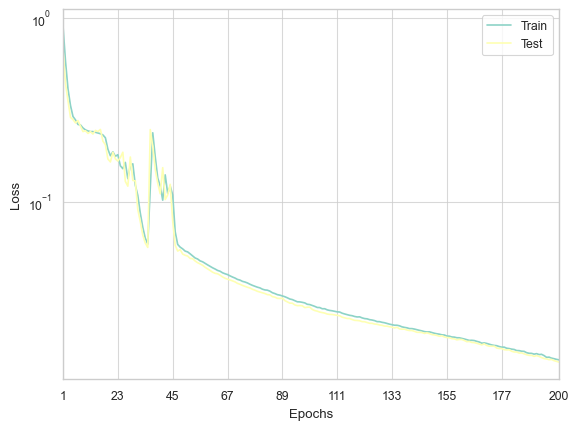

In [74]:
plot_loss_evolution(train_loss, test_loss)

### Evaluation

In [ ]:
# load the best model 
model = PCB_ConvLSTM(input_channels=3, hidden_dim=32, kernel_size=(3, 3), height=13, width=13).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

with torch.no_grad():
    y_pred = model(input_validation)  # (B, T, 1, H, W)
    val_loss = criterion(y_pred, output_validation)
    print(f"Test Loss: {val_loss.item():.6f}")

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_19472\3683357988.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Loss: 0.013947


### Plotting results

We are going to plot the temperature evolution in the four nodes corresponding with the heaters

In [76]:
id_heaters = [(6,3), (3,6), (9,3), (9,9)]

Boundary conditions

In [77]:
Q_heaters = np.array([1.0, 1.0, 1.0, 1.0])
T_interfaces = np.array([250, 250, 250, 250])
T_env = 250

Actual values

In [78]:
T, _, _, _ = PCB_case_2(solver = 'transient', display=False, time = time_sim, dt = dt, T_init = T_init, Q_heaters = Q_heaters, T_interfaces = T_interfaces, Tenv = T_env) # heaters in default position
T = T.reshape(T.shape[0], nodes_side, nodes_side) # reshaping the data grid-shape

Predicted values

In [79]:
input = get_input(Q_heaters, T_interfaces, T_env)

output = model(input)
output_denorm = output*output_std + output_mean
T_pred = output_denorm[0,:,0,:,:].cpu().detach().numpy()

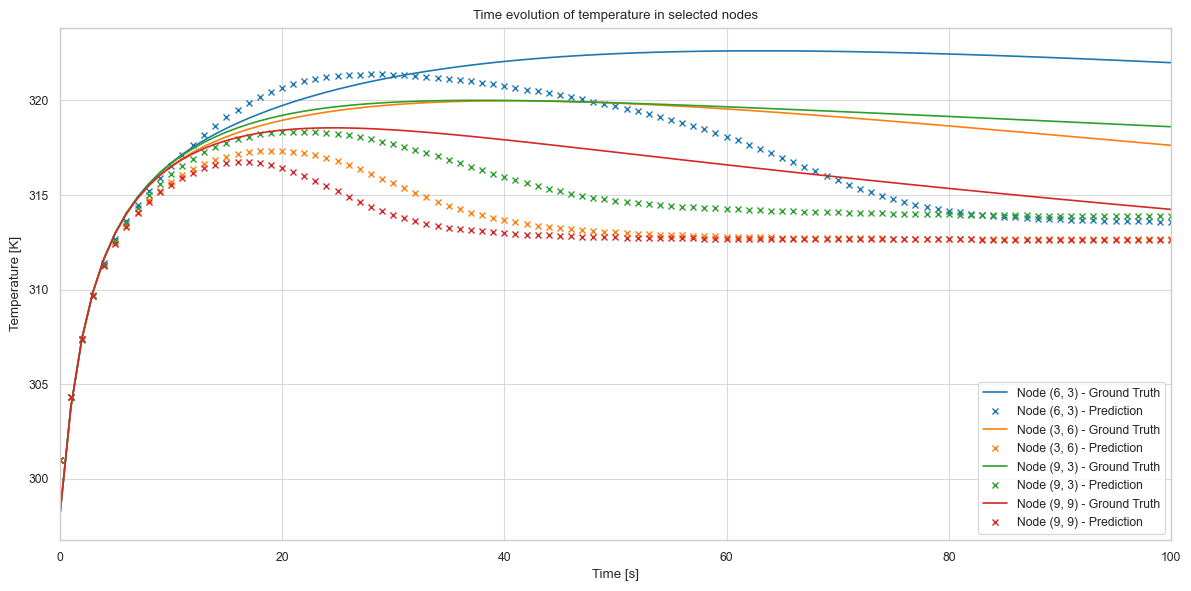

In [80]:
plot_nodes_evolution(T_pred, T, id_heaters, together=True)

## Physics informed Convolutional LSTM

In [81]:
from Physics_Loss import *

### New loss function validation

Validation of the Physics loss function

In [82]:
# Crear instancia de la clase de pérdida
physics_loss = PhysicsLossTransient().to(device)

# Parámetros
B = 1        # batch size
H = W = 13    # dimensiones espaciales

# Obtener datos reales del solver
T2, _, interfaces2, heaters2 = PCB_case_2(solver='transient', display=False, time=100, dt=1, T_init=298.0)
T = T2.shape[0]      # número de pasos temporales

# Temperatura: [B, T, 1, 13, 13]
T_tensor = torch.tensor(T2, dtype=torch.float32).view(T, 1, H, W).unsqueeze(0).repeat(B, 1, 1, 1, 1).to(device)

interfaces_input = torch.tensor([list(interfaces2.values())], dtype=torch.float32).repeat(B, 1).to(device) # [B, 4]
heaters_input = torch.tensor([list(heaters2.values())], dtype=torch.float32).repeat(B, 1).to(device) # [B, 4]
Tenv = torch.full((B, 1), 250.0).to(device) # [B, 1]

# Calcular la pérdida
loss = physics_loss(
    T_pred=T_tensor,
    T_true=T_tensor,
    heaters_input=heaters_input,
    interfaces_input=interfaces_input,
    Tenv=Tenv
)

# # Mostrar resultado
print(f"Physics loss (esperada ≈ 0): {loss.item():.6e}")

Physics loss (esperada ≈ 0): 2.517081e-12


Validation of the boundary loss function

In [83]:
# # Crear una instancia de BoundaryLoss con valores predeterminados
# boundary_loss = BoundaryLoss()

# # Ejemplo de tensores
# interfaces_example = torch.tensor(list(interfaces2.values()), dtype=torch.float32).unsqueeze(0)

# # Calcular la pérdida
# loss = boundary_loss(T2, interfaces_example)
# print("Pérdida en las interfaces:", loss.item())

Función para extraer las condiciones de contorno de los tensores de los 3 canales

In [84]:
def extract_boundary_conditions_from_dataset(input_tensor, dataset: PCBDataset, nodes_side=13):
    """
    Extrae las condiciones de contorno originales (desnormalizadas) a partir de un input_tensor y el dataset asociado.
    input_tensor: tensor de forma [batch, sequence_length, 3, nodes_side, nodes_side]
    """
    input_0 = input_tensor[0, 0]  # [3, 13, 13]

    T_interfaces1 = input_0[0]
    Q_heaters1 = input_0[1]
    T_env1 = input_0[2]

    # Extraer los valores originales usando los métodos de desnormalización del dataset
    T_interfaces_raw = torch.tensor([
        T_interfaces1[0, 0],
        T_interfaces1[0, nodes_side - 1],
        T_interfaces1[nodes_side - 1, nodes_side - 1],
        T_interfaces1[nodes_side - 1, 0]
    ], device=input_tensor.device)
    T_interfaces_in = dataset.denormalize_T_interfaces(T_interfaces_raw)

    Q_heaters_raw = torch.tensor([
        Q_heaters1[6, 3],
        Q_heaters1[3, 6],
        Q_heaters1[9, 3],
        Q_heaters1[9, 9]
    ], device=input_tensor.device)
    Q_heaters_in = dataset.denormalize_Q_heaters(Q_heaters_raw)

    T_env_in = dataset.denormalize_T_env(T_env1[0, 0])

    return Q_heaters_in, T_interfaces_in, T_env_in


def extract_all_boundary_conditions(input_tensor, dataset: PCBDataset, nodes_side=13):
    """
    Extrae las condiciones de contorno desnormalizadas de todos los ejemplos del batch.
    Retorna tres listas: Q_heaters_all, T_interfaces_all, T_env_all.
    """
    batch_size = input_tensor.shape[0]
    Q_heaters_all = []
    T_interfaces_all = []
    T_env_all = []

    for i in range(batch_size):
        q, t_int, t_env = extract_boundary_conditions_from_dataset(input_tensor[i:i+1], dataset, nodes_side)
        Q_heaters_all.append(q)
        T_interfaces_all.append(t_int)
        T_env_all.append(t_env)

    Q_heaters_all = torch.stack(Q_heaters_all)       # [batch_size, 4]
    T_interfaces_all = torch.stack(T_interfaces_all) # [batch_size, 4]
    T_env_all = torch.stack(T_env_all)               # [batch_size]

    return Q_heaters_all, T_interfaces_all, T_env_all


In [85]:
Q_heaters_train, T_interfaces_train, T_env_train = extract_all_boundary_conditions(input_train, dataset_train)
Q_heaters_test, T_interfaces_test, T_env_test = extract_all_boundary_conditions(input_test, dataset_test)
Q_heaters_validation, T_interfaces_validation, T_env_validation = extract_all_boundary_conditions(input_validation, dataset_validation)

# DEBUGGING
# print("Q_heaters_all.shape:", Q_heaters_train.shape)
# print("T_interfaces_all.shape:", T_interfaces_train.shape)
# print("T_env_all.shape:", T_env_train.shape)

# # Ejemplo del primero
# print("Ejemplo 0:")
# print("Q_heaters:", Q_heaters_train[0])
# print("T_interfaces:", T_interfaces_train[0])
# print("T_env:", T_env_train[0])


### Training

Hyperparameters of training

In [86]:
phy_param = 0.001
bnd_param = 0.001

In [87]:
# Función auxiliar para preparar datos (con repetición temporal)
def prepare_data_with_bc(dataset, device):
    inputs, outputs, q, t_int, t_env = zip(*[dataset[i] for i in range(len(dataset))])
    
    # Convertir listas a tensores
    outputs = torch.stack(outputs)                          # [B, T, 1, 13, 13] (incluye todos los pasos temporales)
    inputs = torch.stack(inputs)                            # [B, 3, 13, 13] 
    inputs = inputs.unsqueeze(1).repeat(1, outputs.shape[1], 1, 1, 1)  # [B, T, 3, 13, 13] (repetir en el tiempo)
    q = torch.stack(q).view(len(dataset), -1)               # [B, 4]
    t_int = torch.stack(t_int).view(len(dataset), -1)       # [B, 4]
    t_env = torch.stack(t_env).view(len(dataset), -1)       # [B, 1]
    
    # Asegurarse de que outputs tenga la forma correcta
    if outputs.ndim == 4:  # Si outputs no tiene dimensión temporal
        outputs = outputs.unsqueeze(2)                     # [B, T, 1, 13, 13]

    # print("inputs.shape:", inputs.shape)   # DEBUGGING
    # print("outputs.shape:", outputs.shape)  # DEBUGGING

    # Concatenar todas las condiciones de contorno
    bc_all = torch.cat([q, t_int, t_env], dim=1)            # [B, 9]

    # Mover a dispositivo
    return TensorDataset(inputs.to(device), outputs.to(device), bc_all.to(device))

In [88]:
from Dataset_Class import PCBDataset  # Ensure the PCBDataset class is imported

dataset_path = os.path.join(dir_path,'Datasets')

# Allowlist the PCBDataset class for safe loading
torch.serialization.add_safe_globals([PCBDataset])

dataset_test:PCBDataset = torch.load(os.path.join(dataset_path,'PCB_transient_dataset_test.pth'), weights_only=True)
dataset_train:PCBDataset = torch.load(os.path.join(dataset_path,'PCB_transient_dataset_train.pth'), weights_only=True)
dataset_validation:PCBDataset = torch.load(os.path.join(dataset_path,'PCB_transient_dataset_validation.pth'), weights_only=True)

dataset_train.return_bc = True
dataset_test.return_bc = True
dataset_validation.return_bc = True


# Preparar datasets
train_ds = prepare_data_with_bc(dataset_train, device)
test_ds = prepare_data_with_bc(dataset_test, device)
validation_ds = prepare_data_with_bc(dataset_validation, device)

In [89]:
from convlstm import *

class PCB_ConvLSTM_physics(nn.Module):
    def __init__(self, input_channels=3, hidden_dim=32, kernel_size=(3, 3), height=13, width=13):
        super().__init__()
        self.convlstm = ConvLSTM(input_dim=input_channels,
                                 hidden_dim=[hidden_dim],
                                 kernel_size=kernel_size,
                                 num_layers=1,
                                 batch_first=True,
                                 bias=True,
                                 return_all_layers=False)
        
        self.decoder = nn.Conv2d(hidden_dim, 1, kernel_size=1)

    def forward(self, x):
        # x: (B, T, C, H, W)
        lstm_out, _ = self.convlstm(x)  # lstm_out[0]: (B, T, hidden_dim, H, W)

        # Apply decoder to each time step
        decoded = [self.decoder(lstm_out[0][:, t]) for t in range(x.size(1))]
        output = torch.stack(decoded, dim=1)  # (B, T, 1, H, W)
        return output

Definición del modelo

In [90]:
# train_ds = TensorDataset(input_train, output_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# test_ds = TensorDataset(input_test, output_test)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

model = PCB_ConvLSTM_physics(input_channels=3, hidden_dim=hidden_layers, kernel_size=kernel_size, height=13, width=13).to(device)

# Loss criterion
criterion_reconstruction = nn.MSELoss()
criterion_physics = PhysicsLossTransient()
criterion_boundary = BoundaryLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=lrdecay, patience=lrdecay_patience, verbose=True)

# # DEBUGGING
# batch = next(iter(train_dl))
# x, y = batch

# print(f"x está en: {x.device}")
# print(f"y está en: {y.device}")
# print(f"model está en: {next(model.parameters()).device}")

c:\Users\ismael.gallo\anaconda3\envs\ismael_minimal\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training and saving best model with best parameters.

In [ ]:
train_loss = []
test_loss = []
best_test_loss = np.inf
epochs_without_improvement = 0

kernel_string = f"{kernel_size[0]}x{kernel_size[1]}"
model_dir = os.path.join(dir_path, 'models', 'ConvLSTM')
os.makedirs(model_dir, exist_ok=True)

# Nombre del archivo con hiperparámetros
filename = f"PCB_ConvLSTM_nt{n_train}_{time_sim}s_bs{batch_size}_h{hidden_layers}_k{kernel_string}_phy_{phy_param}_bnd{bnd_param}.pth"

# Ruta completa del modelo
model_path = os.path.join(model_dir, filename)

# Comprobar si el modelo ya existe
if os.path.exists(model_path):
    display(Markdown(f"**❌ El modelo `{filename}` ya existe. Se omite esta celda para evitar sobreescritura.**"))
    # Detiene la ejecución de esta celda sin interrumpir el notebook
    raise SystemExit

# ruta para el JSON
json_path = model_path.replace('.pth', '.json')

start_time_training = time.time()
start_datetime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    start_time_epoch = time.time()

    # Entrenamiento
    for x, y, bc_all in tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs} - Training", leave=False):
        optimizer.zero_grad()
        
        q = bc_all[:, 0:4]
        t_int = bc_all[:, 4:8]
        t_env = bc_all[:, 8].unsqueeze(1)
        
        y_hat = model(x)
        
        y_hat_denorm = y_hat * output_std + output_mean
        y_denorm = y * output_std + output_mean
        
        # print("y_hat.shape:", y_hat.shape, "y.shape:", y.shape, "x.shape", x.shape) # DEBUGGING
        
        loss_reconstruction = criterion_reconstruction(y_hat, y)
        loss_physics = criterion_physics(y_hat_denorm, y_denorm, q, t_int, t_env) # NO OLVIDAR DE DENORMALIZAR
        loss_boundary = criterion_boundary(y_hat_denorm, t_int)
        
        loss = loss_reconstruction + phy_param * loss_physics + bnd_param * loss_boundary
        loss.backward()
        optimizer.step()
        total_loss += loss.detach().item()

    epoch_train_loss = total_loss / len(train_dl)
    train_loss.append(epoch_train_loss)

    # Validación
    model.eval()
    total_test_loss = 0.0
    with torch.no_grad():
        for x_test, y_test, bc_test in test_dl:
            
            q = bc_test[:, 0:4]
            t_int = bc_test[:, 4:8]
            t_env = bc_test[:, 8].unsqueeze(1)
            
            y_pred = model(x_test)
            y_pred_denorm = y_pred * output_std + output_mean
            y_test_denorm = y_test * output_std + output_mean
            
            loss_test_reconstruction = criterion_reconstruction(y_pred, y_test)
            loss_test_physics = criterion_physics(y_pred_denorm, y_test_denorm, q, t_int, t_env)
            loss_test_boundary = criterion_boundary(y_pred_denorm, t_int)
            
            test = loss_test_reconstruction + phy_param * loss_test_physics + bnd_param * loss_test_boundary
            total_test_loss += test.item()

    epoch_test_loss = total_test_loss / len(test_dl)
    test_loss.append(epoch_test_loss)
    
    # Scheduler update
    scheduler.step(epoch_test_loss)
    
    # Early stopping check
    if epoch_test_loss < best_test_loss:
        best_test_loss = epoch_test_loss
        
        # Guardar el modelo
        torch.save(model.state_dict(), model_path)
        
        elapsed_training = time.time() - start_time_training
        elapsed_minutes = elapsed_training / 60
    
        # Guardar hiperparámetros en JSON  
        params = {
            'start_datetime': start_datetime,
            'training_duration_minutes': elapsed_minutes,
            "system_specs": system_specs,
            'hidden_layers': hidden_layers,
            'kernel_size': kernel_string,
            'batch_size': batch_size,
            'lr': lr,
            "scheduler":{
                "type": "ReduceLROnPlateau",
                "factor": lrdecay,
                "patience": lrdecay_patience
            },
            'early_stop_patience': early_stop_patience,
            'epochs_trained': epoch + 1,
            'best_test_loss': best_test_loss,
            "train_loss": list(map(float, train_loss)),
            "test_loss": list(map(float, test_loss)),
        }
        
        with open(json_path, 'w') as f:
            json.dump(params, f, indent=4)
    
        # print(f"✓ Saving model (epoch {epoch+1}) | test_loss improved to {best_test_loss:.6f}")
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        # print(f"No improvement for {epochs_without_improvement} epoch(s)")
        
    if epochs_without_improvement >= early_stop_patience:
        print(f"⚠️ Early stopping at epoch {epoch+1} — no improvement for {early_stop_patience} epochs.")
        break

    # Estadísticas finales de la época
    elapsed_epoch = time.time() - start_time_epoch
    # print(f"Epoch {epoch+1:3d} | Train Loss: {epoch_train_loss:.6f} | Test Loss: {epoch_test_loss:.6f} | Time: {elapsed_epoch:.2f}s")
    
print(f"Entrenamiento finalizado en {elapsed_minutes:.2f} minutos.")

Epoch 36/200 - Training:  38%|███▊      | 6/16 [00:05<00:09,  1.07it/s] 

Plotting validation loss and train loss

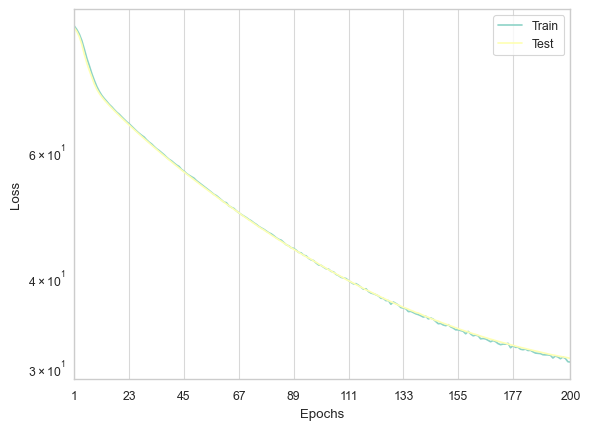

In [ ]:
plot_loss_evolution(train_loss, test_loss)

### Evaluation

In [ ]:
# load the best model 
model = PCB_ConvLSTM_physics(input_channels=3, hidden_dim=32, kernel_size=(3, 3), height=13, width=13).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

criterion = nn.MSELoss() # para comparar colo con la recostrucción

with torch.no_grad():
    y_pred = model(input_validation)  # (B, T, 1, H, W)
    val_loss = criterion(y_pred, output_validation)
    print(f"Test Loss: {val_loss.item():.6f}")

Test Loss: 11.643674


C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_19472\817707752.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


### Plotting results

We are going to plot the temperature evolution in the four nodes corresponding with the heaters

In [ ]:
id_heaters = [(6,3), (3,6), (9,3), (9,9)]

Boundary conditions

In [ ]:
Q_heaters = np.array([1.0, 1.0, 1.0, 1.0])
T_interfaces = np.array([250, 250, 250, 250])
T_env = 250

Actual values

In [ ]:
T, _, _, _ = PCB_case_2(solver = 'transient', display=False, time = time_sim, dt = dt, T_init = T_init, Q_heaters = Q_heaters, T_interfaces = T_interfaces, Tenv = T_env) # heaters in default position
T = T.reshape(T.shape[0], nodes_side, nodes_side) # reshaping the data grid-shape

Predicted values

In [ ]:
input = get_input(Q_heaters, T_interfaces, T_env)

output = model(input)
output_denorm = output*output_std + output_mean
T_pred = output_denorm[0,:,0,:,:].cpu().detach().numpy()

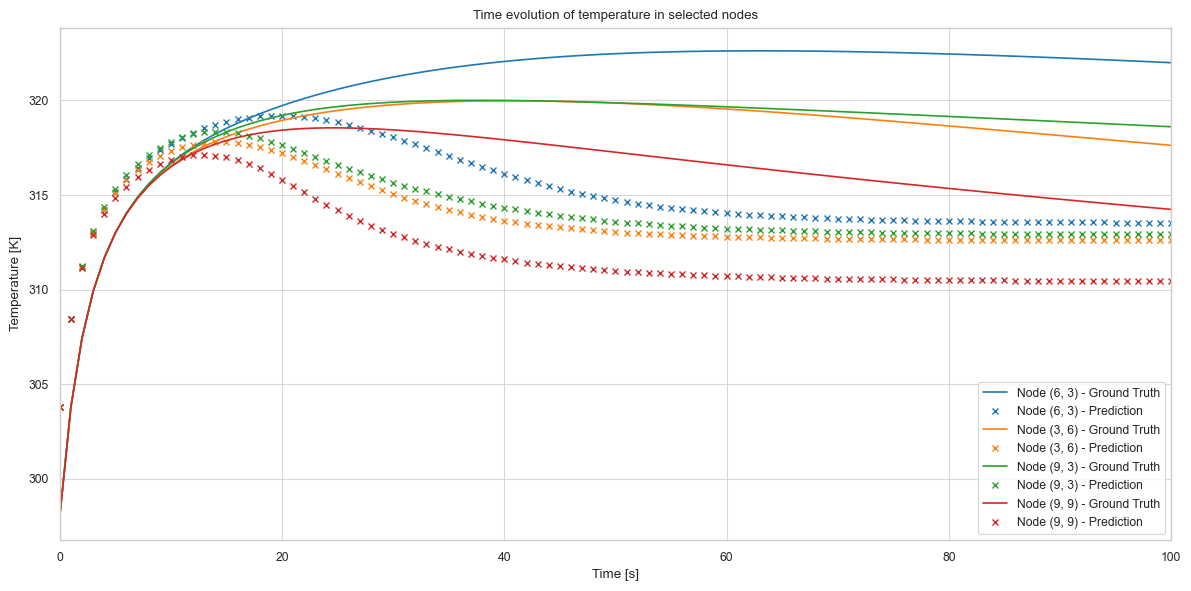

In [ ]:
plot_nodes_evolution(T_pred, T, id_heaters, together=True)

Error en la predicción

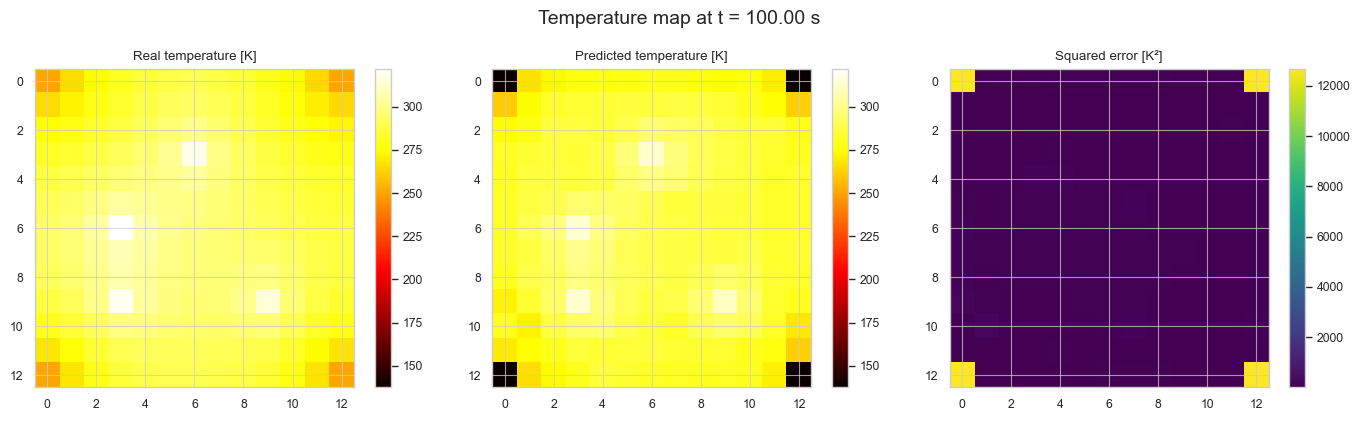

MSE: 337.11333121 K^2


In [ ]:
plot_se_map(T_pred, T, time=100, show_pred=True)

Error en la predicción

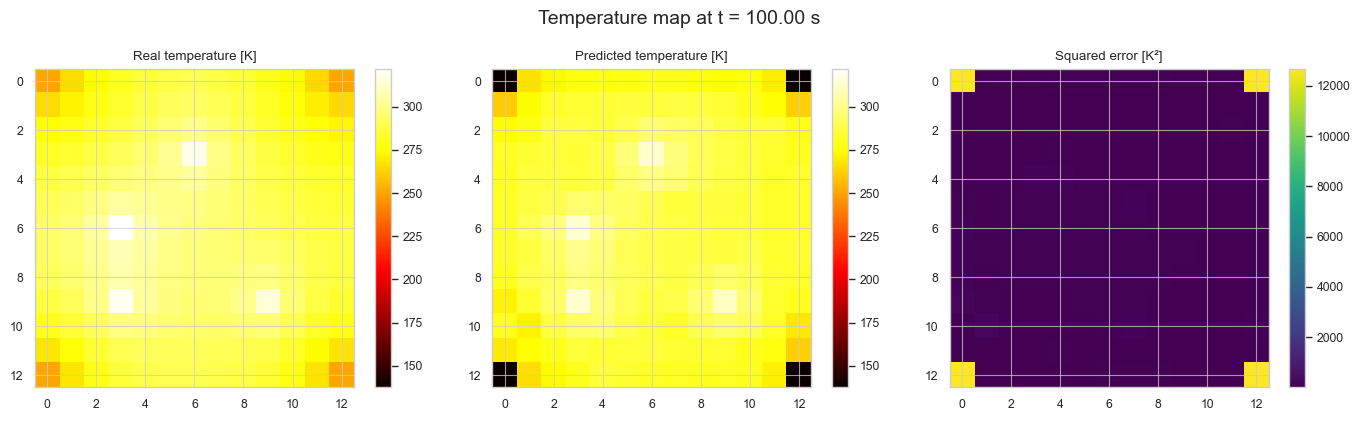

MSE: 337.11333121 K^2


In [ ]:
plot_se_map(T_pred, T, time=100, show_pred=True)